### Imports

In [105]:
import numpy as np

# Add models here
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

# Sklearn imports for processing and evaluation
from sklearn.decomposition import PCA
from sklearn.metrics import median_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Plotting
from matplotlib import pyplot as plt

# Misc
import time
from tqdm import tqdm

from sklearn.decomposition import PCA

### Load Data

In [106]:
x_train = np.loadtxt("./uci_har_dataset/train/X_train.txt")
y_train = np.loadtxt("./uci_har_dataset/train/y_train.txt")

x_test = np.loadtxt("./uci_har_dataset/test/X_test.txt")
y_test = np.loadtxt("./uci_har_dataset/test/y_test.txt")

### Combine Data

In [107]:
combined_x = np.concatenate((x_train, x_test))
combined_y = np.concatenate((y_train, y_test))

assert combined_x.shape[0] == x_train.shape[0] + x_test.shape[0]
assert combined_y.shape[0] == y_train.shape[0] + y_test.shape[0]

In [108]:
pca = PCA(n_components=2)
t_x = pca.fit_transform(combined_x)

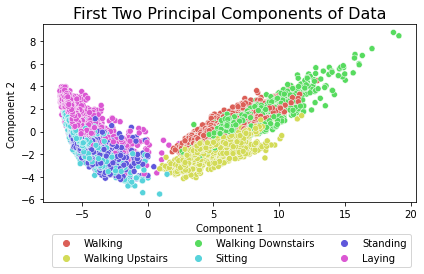

In [112]:
df = pd.DataFrame()
df["y"] = combined_y
df["Component 1"] = t_x[:,0]
df["Component 2"] = t_x[:,1]

ax = sns.scatterplot(x="Component 1", y="Component 2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 6),
                data=df)#.set(title="Data after t-SNE") 

handles, label  =  ax.get_legend_handles_labels()

ax.legend(handles, ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying'],
          bbox_to_anchor=[1.0,-0.15], ncol=3)
ax.set_title("First Two Principal Components of Data", fontsize=16)
plt.tight_layout()
#plt.show()
plt.savefig("pca_data.png")

### Plot Results and Timing

In [113]:
def plot_results(results, times, num_features):
    # Get means
    acc_mean = np.mean(results, axis=1)
    acc_stds = np.std(results, axis=1)
    time_mean = np.mean(times, axis=1)
    time_stds = np.std(times, axis=1)

    # Plot prediction accuracies
    fig, ax = plt.subplots()
    ax.plot(num_features, acc_mean)
    ax.fill_between(num_features, acc_mean+acc_stds, acc_mean-acc_stds, alpha=0.3)
    ax.set(title="Prediction Accuracies", xlabel="Number of PCA Components", ylabel="Prediction Acciracy")
    plt.show()

    # Plot timing
    fig, ax = plt.subplots()
    ax.plot(num_features, time_mean)
    ax.fill_between(num_features, time_mean+time_stds, time_mean-time_stds, alpha=0.3)
    ax.set(title="Training Time", xlabel="Number of PCA Components", ylabel="Time (s)")
    plt.show()

### KFold

In [118]:
def do_kfold_pca(model, x_data, y_data, features='all', folds=10):
     
    # Do KFold
    kf = KFold(folds)
    
    # KF training
    pred_accuracy = []
    fit_times = []
    for idx, (train_idx, test_idx) in tqdm(enumerate(kf.split(x_data))):    
        
        # Do PCA
        features = x_data.shape[1] if(features == 'all') else features
        pca = PCA(n_components=features)
        scalar = StandardScaler().fit(x_data[train_idx])
        standardized = scalar.transform(x_data[train_idx])
        transformed = pca.fit_transform(standardized)
        
        # Fit and time model
        start = time.time()
        model.fit(transformed, y_data[train_idx])
        fit_times.append(time.time() - start)
        
        # Transform test data and evaluate
        test_transform = np.dot(scalar.transform(x_data[test_idx]), pca.components_.T)
        preds = model.predict(test_transform)
        score = accuracy_score(preds, y_data[test_idx])
        pred_accuracy.append(score)
        
    print(r"{0} FEATURES PREDICTION ACCURACY: {1:.3f} $\pm$ {2:.3f}".format(features, np.mean(pred_accuracy), np.std(pred_accuracy)))
    return pred_accuracy, fit_times, model

### Training for Different Number of PCA Components GradientBoostingClassifier

In [119]:
# Number of PCA Components
num_features = [1,2,3,4,5,10,20,50]

results = []
times = []
for features in num_features:
    #pred_accuracy, fit_times = do_kfold_pca(GradientBoostingClassifier(n_estimators=10), combined_x, combined_y, features=features)
    pred_accuracy, fit_times, model = do_kfold_pca(SVC(kernel='linear'), combined_x, combined_y, features=features)
    break
    results.append(pred_accuracy)
    times.append(fit_times)

10it [00:20,  2.07s/it]

1 FEATURES PREDICTION ACCURACY: 0.434 $\pm$ 0.042


[[ 0.11857849]
 [-0.1223412 ]
 [ 0.524632  ]
 [ 0.88457418]
 [ 0.36006872]
 [-0.1640032 ]
 [ 0.6605207 ]
 [ 0.73464441]
 [ 0.31549729]
 [ 0.48963689]
 [ 0.48374197]
 [ 0.37887509]
 [-0.2836821 ]
 [ 0.12937978]
 [ 0.29299595]]


TypeError: only size-1 arrays can be converted to Python scalars

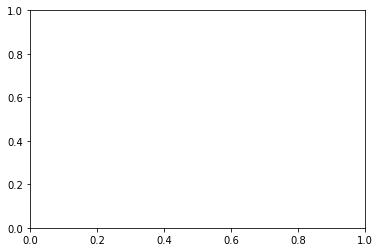

In [120]:
print(model.coef_)

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()



features_names = ['input1', 'input2']
f_importances(model.coef_, features_names)

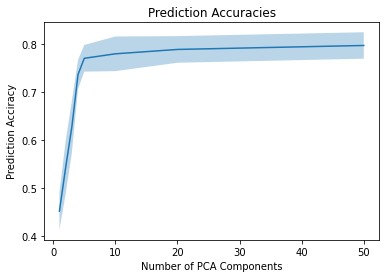

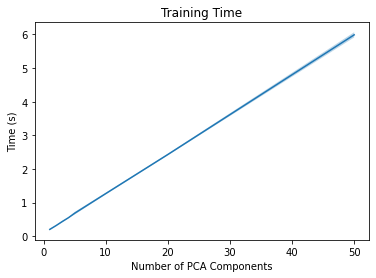

In [7]:
plot_results(results, times, num_features)

In [8]:
model = GradientBoostingClassifier(n_estimators=10)
model.fit(x_train, y_train)
print("BASELINE GRADIENTBOOSTINGCLASSIFIER ACCURACY: {}".format(model.score(x_test, y_test)))

BASELINE GRADIENTBOOSTINGCLASSIFIER ACCURACY: 0.8917543264336614


### Training for Different Number of PCA Components RandomForestClassifier

In [9]:
# Num### Training for Different Number of PCA Components RandomForestClassifierber of PCA Components
num_features = [1,2,3,4,5,10,20,50]

results = []
times = []
for features in num_features:
    pred_accuracy, fit_times = do_kfold_pca(RandomForestClassifier(n_estimators=10), combined_x, combined_y, features=features)
    results.append(pred_accuracy)
    times.append(fit_times)

10it [00:02,  3.53it/s]


1 FEATURES PREDICTION ACCURACY: 0.387 $\pm$ 0.016


10it [00:02,  3.63it/s]


2 FEATURES PREDICTION ACCURACY: 0.516 $\pm$ 0.029


10it [00:02,  3.87it/s]


3 FEATURES PREDICTION ACCURACY: 0.636 $\pm$ 0.053


10it [00:02,  3.40it/s]


4 FEATURES PREDICTION ACCURACY: 0.742 $\pm$ 0.026


10it [00:03,  3.22it/s]


5 FEATURES PREDICTION ACCURACY: 0.764 $\pm$ 0.031


10it [00:04,  2.21it/s]


10 FEATURES PREDICTION ACCURACY: 0.805 $\pm$ 0.027


10it [00:05,  1.80it/s]


20 FEATURES PREDICTION ACCURACY: 0.827 $\pm$ 0.025


10it [00:07,  1.33it/s]

50 FEATURES PREDICTION ACCURACY: 0.841 $\pm$ 0.018


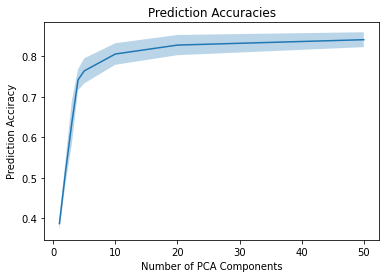

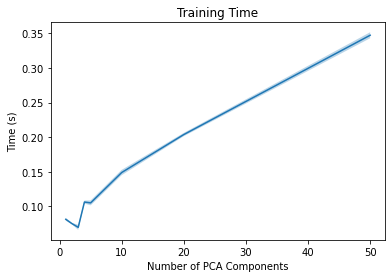

In [10]:
plot_results(results, times, num_features)

In [11]:
model = RandomForestClassifier(n_estimators=10)
model.fit(x_train, y_train)
print("BASELINE RANDOMFORESTLASSIFIER ACCURACY: {}".format(model.score(x_test, y_test)))

BASELINE RANDOMFORESTLASSIFIER ACCURACY: 0.9148286392941974


### Psuedo Data

In [6]:
def do_kfold_psudodata(model, x_data, y_data, num_points=100, folds=10, seed=1):
         
    # Do KFold
    kf = KFold(folds)
    
    # KF training
    pred_accuracy = []
    fit_times = []
    
    np.random.seed(seed)
    
    for idx, (train_idx, test_idx) in tqdm(enumerate(kf.split(list(range(len(y_data)))))): 
        
        # Get mean and std for each label
        x_1 = combined_x[train_idx][np.argwhere(combined_y[train_idx] == 1)[:,0]]
        x_2 = combined_x[train_idx][np.argwhere(combined_y[train_idx] == 2)[:,0]]
        x_3 = combined_x[train_idx][np.argwhere(combined_y[train_idx] == 3)[:,0]]
        x_4 = combined_x[train_idx][np.argwhere(combined_y[train_idx] == 4)[:,0]]
        x_5 = combined_x[train_idx][np.argwhere(combined_y[train_idx] == 5)[:,0]]
        x_6 = combined_x[train_idx][np.argwhere(combined_y[train_idx] == 6)[:,0]]

        mean_1 = np.mean(x_1, axis=0)
        std_1 = np.std(x_1, axis=0)
        mean_2 = np.mean(x_2, axis=0)
        std_2 = np.std(x_2, axis=0)
        mean_3 = np.mean(x_3, axis=0)
        std_3 = np.std(x_3, axis=0)
        mean_4 = np.mean(x_4, axis=0)
        std_4 = np.std(x_4, axis=0)
        mean_5 = np.mean(x_5, axis=0)
        std_5 = np.std(x_5, axis=0)
        mean_6 = np.mean(x_6, axis=0)
        std_6 = np.std(x_6, axis=0)
    
        # Sample Pseudodata
        sampled_x1 = np.random.multivariate_normal(mean_1, std_1*np.eye(len(std_1)), num_points)
        sampled_x2 = np.random.multivariate_normal(mean_2, std_2*np.eye(len(std_2)), num_points)
        sampled_x3 = np.random.multivariate_normal(mean_3, std_3*np.eye(len(std_3)), num_points)
        sampled_x4 = np.random.multivariate_normal(mean_4, std_4*np.eye(len(std_4)), num_points)
        sampled_x5 = np.random.multivariate_normal(mean_5, std_5*np.eye(len(std_5)), num_points)
        sampled_x6 = np.random.multivariate_normal(mean_6, std_6*np.eye(len(std_6)), num_points)

        # Combine pseudodata
        sampled_combined = np.concatenate([sampled_x1, sampled_x2, sampled_x3, sampled_x4, sampled_x5, sampled_x6])

        # Get labels
        labels = np.ones(len(sampled_combined))
        for i in range(1,7):
            labels[(i-1)*num_points:(i)*num_points] *= i

        # Fit and time model
        start = time.time()
        model.fit(sampled_combined, labels)
        fit_times.append(time.time() - start)
        
        # Score model
        preds = model.predict(x_data[test_idx])
        score = accuracy_score(preds, y_data[test_idx])
        pred_accuracy.append(score)
        
    print(r"{0} POINTS PREDICTION ACCURACY: {1:.3f} $\pm$ {2:.3f}".format(num_points, np.mean(pred_accuracy), np.std(pred_accuracy)))
    return pred_accuracy, fit_times

In [92]:
np.random.seed(1)
num_points = 500 
        
# Get mean and std for each label
x_1 = combined_x[np.argwhere(combined_y == 1)[:,0]]
x_2 = combined_x[np.argwhere(combined_y == 2)[:,0]]
x_3 = combined_x[np.argwhere(combined_y == 3)[:,0]]
x_4 = combined_x[np.argwhere(combined_y == 4)[:,0]]
x_5 = combined_x[np.argwhere(combined_y == 5)[:,0]]
x_6 = combined_x[np.argwhere(combined_y == 6)[:,0]]

mean_1 = np.mean(x_1, axis=0)
std_1 = np.std(x_1, axis=0)
mean_2 = np.mean(x_2, axis=0)
std_2 = np.std(x_2, axis=0)
mean_3 = np.mean(x_3, axis=0)
std_3 = np.std(x_3, axis=0)
mean_4 = np.mean(x_4, axis=0)
std_4 = np.std(x_4, axis=0)
mean_5 = np.mean(x_5, axis=0)
std_5 = np.std(x_5, axis=0)
mean_6 = np.mean(x_6, axis=0)
std_6 = np.std(x_6, axis=0)
    
# Sample Pseudodata
sampled_x1 = np.random.multivariate_normal(mean_1, std_1*np.eye(len(std_1)), num_points)
sampled_x2 = np.random.multivariate_normal(mean_2, std_2*np.eye(len(std_2)), num_points)
sampled_x3 = np.random.multivariate_normal(mean_3, std_3*np.eye(len(std_3)), num_points)
sampled_x4 = np.random.multivariate_normal(mean_4, std_4*np.eye(len(std_4)), num_points)
sampled_x5 = np.random.multivariate_normal(mean_5, std_5*np.eye(len(std_5)), num_points)
sampled_x6 = np.random.multivariate_normal(mean_6, std_6*np.eye(len(std_6)), num_points)

# Combine pseudodata
sampled_combined = np.concatenate([sampled_x1, sampled_x2, sampled_x3, sampled_x4, sampled_x5, sampled_x6])

# Get labels
labels = np.ones(len(sampled_combined))
for i in range(1,7):
    labels[(i-1)*num_points:(i)*num_points] *= i

In [93]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(sampled_combined) 

import pandas as pd
df = pd.DataFrame()
df["y"] = labels
df["Component 1"] = z[:,0]
df["Component 2"] = z[:,1]

/home/mlai/anaconda3/envs/auglichem/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mlai/anaconda3/envs/auglichem/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 1.851350
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.455566
[t-SNE] KL divergence after 1000 iterations: 2.846088


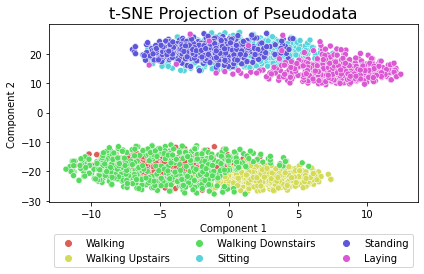

In [94]:
ax = sns.scatterplot(x="Component 1", y="Component 2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 6),
                data=df)#.set(title="Data after t-SNE") 

handles, label  =  ax.get_legend_handles_labels()

ax.legend(handles, ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying'],
          bbox_to_anchor=[1.0,-0.15], ncol=3)
ax.set_title("t-SNE Projection of Pseudodata", fontsize=16)
plt.tight_layout()
#plt.show()
plt.savefig("tsne_psuedodata.png")

In [101]:
print(np.unique(combined_y, return_counts=True))

(array([1., 2., 3., 4., 5., 6.]), array([1722, 1544, 1406, 1777, 1906, 1944]))


In [121]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(combined_x) 

df = pd.DataFrame()
df["y"] = combined_y
df["Component 1"] = z[:,0]
df["Component 2"] = z[:,1]

#sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
#                palette=sns.color_palette("hls", 6),
#                data=df).set(title="Data after t-SNE") 

/home/mlai/anaconda3/envs/auglichem/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mlai/anaconda3/envs/auglichem/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10299 samples in 0.003s...
[t-SNE] Computed neighbors for 10299 samples in 1.598s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10299
[t-SNE] Computed conditional probabilities for sample 2000 / 10299
[t-SNE] Computed conditional probabilities for sample 3000 / 10299
[t-SNE] Computed conditional probabilities for sample 4000 / 10299
[t-SNE] Computed conditional probabilities for sample 5000 / 10299
[t-SNE] Computed conditional probabilities for sample 6000 / 10299
[t-SNE] Computed conditional probabilities for sample 7000 / 10299
[t-SNE] Computed conditional probabilities for sample 8000 / 10299
[t-SNE] Computed conditional probabilities for sample 9000 / 10299
[t-SNE] Computed conditional probabilities for sample 10000 / 10299
[t-SNE] Computed conditional probabilities for sample 10299 / 10299
[t-SNE] Mean sigma: 1.305718
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.193367
[t-SNE] KL 

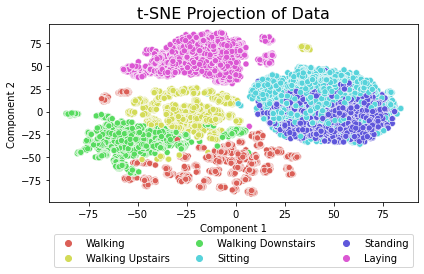

In [122]:
ax = sns.scatterplot(x="Component 1", y="Component 2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 6),
                data=df)#.set(title="Data after t-SNE") 

handles, label  =  ax.get_legend_handles_labels()

ax.legend(handles, ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying'],
          bbox_to_anchor=[1.0,-0.15], ncol=3)
ax.set_title("t-SNE Projection of Data", fontsize=16)
plt.tight_layout()
#plt.show()
plt.savefig("tsne_data.png")

In [98]:
# Number of Psuedo data points
num_points = [10, 50, 100, 200, 500]

results = []
times = []
for num in num_points:
    pred_accuracy, fit_times = do_kfold_psudodata(RandomForestClassifier(n_estimators=10), combined_x, combined_y, num_points=num)
    results.append(pred_accuracy)
    times.append(fit_times)


10it [00:01,  5.52it/s]


10 POINTS PREDICTION ACCURACY: 0.572 $\pm$ 0.081


10it [00:01,  5.33it/s]


50 POINTS PREDICTION ACCURACY: 0.718 $\pm$ 0.044


10it [00:02,  4.57it/s]


100 POINTS PREDICTION ACCURACY: 0.779 $\pm$ 0.040


10it [00:02,  3.48it/s]


200 POINTS PREDICTION ACCURACY: 0.776 $\pm$ 0.028


10it [00:05,  1.82it/s]

500 POINTS PREDICTION ACCURACY: 0.803 $\pm$ 0.050


In [99]:
mean_svm_sub_acc = np.mean(results, axis=1)
std_svm_sub_acc = np.std(results, axis=1)

mean_svm_sub_time = np.mean(times, axis=1)
std_svm_sub_time = np.std(times, axis=1)

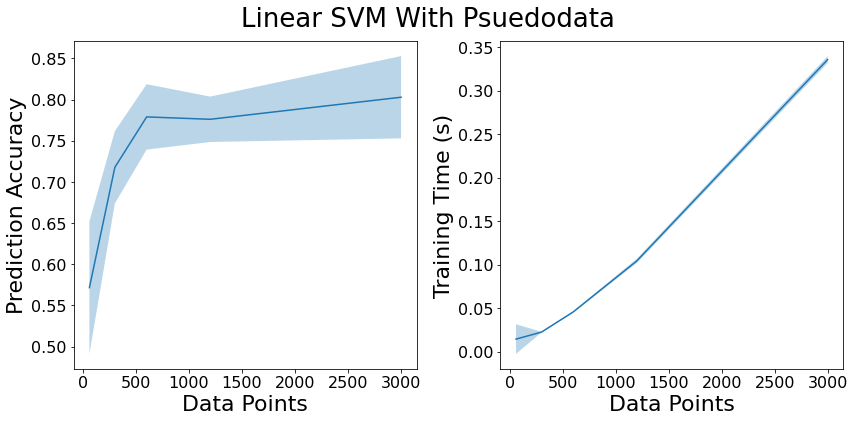

In [104]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

tot_num_points = [6*n for n in num_points]
fig.suptitle("Linear SVM With Psuedodata", fontsize=26, y=0.97)
ax[0].plot(tot_num_points, mean_svm_sub_acc)
ax[0].fill_between(tot_num_points, mean_svm_sub_acc+std_svm_sub_acc, mean_svm_sub_acc-std_svm_sub_acc, alpha=0.3)
ax[1].plot(tot_num_points, mean_svm_sub_time)
ax[1].fill_between(tot_num_points, mean_svm_sub_time+std_svm_sub_time, mean_svm_sub_time-std_svm_sub_time, alpha=0.3)

ax[0].set_xlabel("Data Points", fontsize=22)
ax[0].set_ylabel("Prediction Accuracy", fontsize=22)

ax[1].set_xlabel("Data Points", fontsize=22)
ax[1].set_ylabel("Training Time (s)", fontsize=22)

ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig("./psuedo_data_acc_time.png")
plt.show()

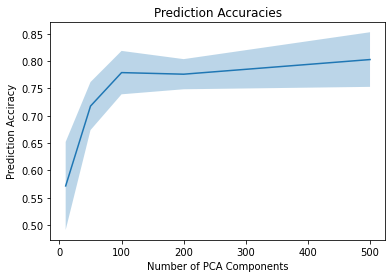

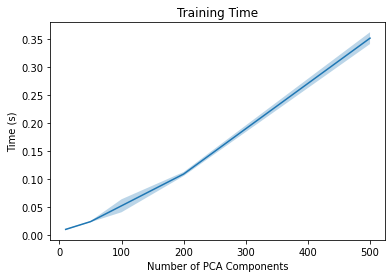

In [8]:
plot_results(results, times, num_points)

In [15]:
# Number of Psuedo data points
num_points = [10, 50, 100, 200, 500]

results = []
times = []
for num in num_points:
    pred_accuracy, fit_times = do_kfold_psudodata(GradientBoostingClassifier(n_estimators=10), combined_x, combined_y, num_points=num)
    results.append(pred_accuracy)
    times.append(fit_times)

10it [00:08,  1.13it/s]


10 POINTS PREDICTION ACCURACY: 0.469 $\pm$ 0.055


10it [00:22,  2.23s/it]


50 POINTS PREDICTION ACCURACY: 0.747 $\pm$ 0.052


10it [00:39,  3.94s/it]


100 POINTS PREDICTION ACCURACY: 0.786 $\pm$ 0.059


10it [01:17,  7.79s/it]


200 POINTS PREDICTION ACCURACY: 0.775 $\pm$ 0.025


10it [03:18, 19.81s/it]

500 POINTS PREDICTION ACCURACY: 0.797 $\pm$ 0.048


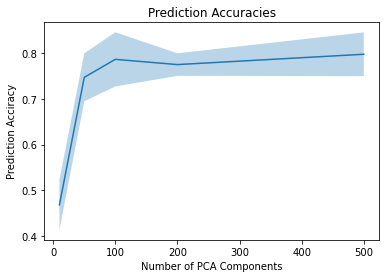

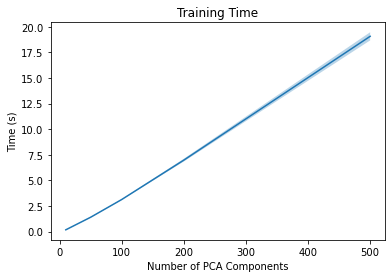

In [16]:
plot_results(results, times, num_points)

### Subsampled data

In [17]:
def do_kfold_subsampled(model, x_data, y_data, num_points=100, folds=10, seed=1):
         
    # Do KFold
    kf = KFold(folds)
    
    np.random.seed(seed)
    
    # KF training
    pred_accuracy = []
    fit_times = []
    for idx, (train_idx, test_idx) in tqdm(enumerate(kf.split(list(range(len(y_data)))))): 
        
        # Get idxs of each label
        idx_1 = np.argwhere(combined_y[train_idx] == 1)[:,0]
        idx_2 = np.argwhere(combined_y[train_idx] == 2)[:,0]
        idx_3 = np.argwhere(combined_y[train_idx] == 3)[:,0]
        idx_4 = np.argwhere(combined_y[train_idx] == 4)[:,0]
        idx_5 = np.argwhere(combined_y[train_idx] == 5)[:,0]
        idx_6 = np.argwhere(combined_y[train_idx] == 6)[:,0]
        
        # Randomly sample num_points from each index
        idx1 = np.random.choice(idx_1, num_points)
        idx2 = np.random.choice(idx_2, num_points)
        idx3 = np.random.choice(idx_3, num_points)
        idx4 = np.random.choice(idx_4, num_points)
        idx5 = np.random.choice(idx_5, num_points)
        idx6 = np.random.choice(idx_6, num_points)
    
        # Sample data
        sampled_x1 = x_data[train_idx][idx1]
        sampled_x2 = x_data[train_idx][idx2]
        sampled_x3 = x_data[train_idx][idx3]
        sampled_x4 = x_data[train_idx][idx4]
        sampled_x5 = x_data[train_idx][idx5]
        sampled_x6 = x_data[train_idx][idx6]

        # Combine pseudodata
        sampled_combined = np.concatenate([sampled_x1, sampled_x2, sampled_x3, sampled_x4, sampled_x5, sampled_x6])

        # Get labels
        labels = np.ones(len(sampled_combined))
        for i in range(1,7):
            labels[(i-1)*num_points:(i)*num_points] *= i

        # Fit and time model
        start = time.time()
        model.fit(sampled_combined, labels)
        fit_times.append(time.time() - start)
        
        # Score model
        preds = model.predict(x_data[test_idx])
        score = accuracy_score(preds, y_data[test_idx])
        pred_accuracy.append(score)
        
    print(r"{0} POINTS PREDICTION ACCURACY: {1:.3f} $\pm$ {2:.3f}".format(num_points, np.mean(pred_accuracy), np.std(pred_accuracy)))
    return pred_accuracy, fit_times

In [18]:
# Number of PCA Components
num_points = [10, 50, 100, 200, 500]

results = []
times = []
for num in num_points:
    pred_accuracy, fit_times = do_kfold_subsampled(RandomForestClassifier(n_estimators=10), combined_x, combined_y, num_points=num)
    results.append(pred_accuracy)
    times.append(fit_times)

10it [00:00, 26.74it/s]


10 POINTS PREDICTION ACCURACY: 0.723 $\pm$ 0.044


10it [00:00, 20.47it/s]


50 POINTS PREDICTION ACCURACY: 0.845 $\pm$ 0.022


10it [00:00, 15.53it/s]


100 POINTS PREDICTION ACCURACY: 0.880 $\pm$ 0.014


10it [00:01,  9.20it/s]


200 POINTS PREDICTION ACCURACY: 0.890 $\pm$ 0.020


10it [00:02,  3.83it/s]

500 POINTS PREDICTION ACCURACY: 0.912 $\pm$ 0.017


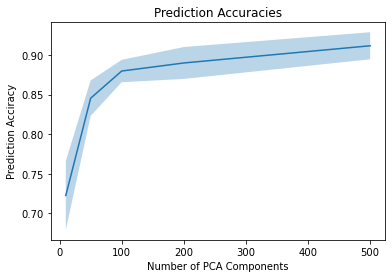

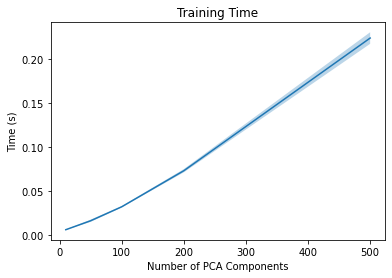

In [19]:
plot_results(results, times, num_points)

In [20]:
# Number of PCA Components
num_points = [10, 50, 100, 200, 500]

results = []
times = []
for num in num_points:
    pred_accuracy, fit_times = do_kfold_subsampled(GradientBoostingClassifier(n_estimators=10), combined_x, combined_y, num_points=num)
    results.append(pred_accuracy)
    times.append(fit_times)

10it [00:02,  4.72it/s]


10 POINTS PREDICTION ACCURACY: 0.628 $\pm$ 0.045


10it [00:13,  1.35s/it]


50 POINTS PREDICTION ACCURACY: 0.833 $\pm$ 0.024


10it [00:29,  2.98s/it]


100 POINTS PREDICTION ACCURACY: 0.883 $\pm$ 0.032


10it [01:03,  6.40s/it]


200 POINTS PREDICTION ACCURACY: 0.892 $\pm$ 0.036


10it [02:57, 17.73s/it]

500 POINTS PREDICTION ACCURACY: 0.903 $\pm$ 0.026


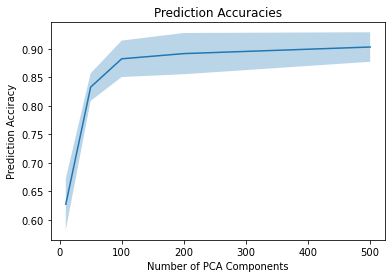

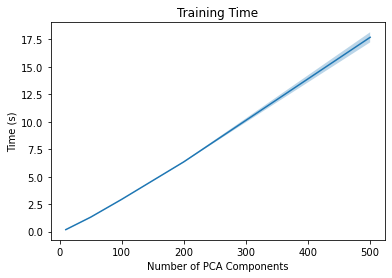

In [21]:
plot_results(results, times, num_points)